In [1]:
import pandas as pd
import os
from collections import Counter, defaultdict
from scipy.stats import scoreatpercentile
import warnings
import numpy as np
from statsmodels.stats import multitest
import venn


from ast import literal_eval
import matplotlib
import numpy
import pandas
import random

import matplotlib.pyplot as plt
%matplotlib inline


import scipy
from scipy.stats import rankdata
from scipy.stats import norm
import pickle
from copy import deepcopy
import csv

from scipy.stats import rankdata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import chain, combinations
import time as timemodule
import ast
from copy import copy

from scipy.stats import zscore
from ast import literal_eval
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ast
import gc
from pyteomics import fasta, parser, mzml
from os import path, listdir
import itertools

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

import math
import statistics

from sklearn import preprocessing
from scipy import optimize
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score



%matplotlib inline


In [ ]:
# Enter here path to project directory
infolder = "/home/sych/tpp_directory/"

In [ ]:
# Create project directory if it is not exist
if not os.path.isdir(infolder):
    os.makedirs(infolder)

In [ ]:
# Move to the project directory
%cd $infolder
%pwd

In [ ]:
# Download feature files from ProteomeXchange

!wget -b ftp://ftp.pride.ebi.ac.uk/pride/archive/projects/PXD051712/*.raw

In [ ]:
# For the next step, you should install ThermoRawFileParser (https://github.com/compomics/ThermoRawFileParser)

In [ ]:
# Run ThermoRawFileParser for all raw files with an option to extract only MS1 spectra

for fn in os.listdir(infolder):
    if fn.endswith('.raw'):
        infile1 = os.path.join(infolder, fn)
        !ThermoRawFileParser -i $infile1 -L 1 -o $infolder

In [ ]:
# (Optional)
# Remove all raw files which were already converted

# for fn in os.listdir(infolder):
#     if fn.endswith('.mzML'):
#         mzmlfile = os.path.join(infolder, fn)
#         rawname = mzmlfile.replace('.mzML', '.raw')
#         if os.path.getsize(mzmlfile) > 78502:
#             if os.path.exists(rawname):
#                 os.remove(rawname)
#         else:
#             print('small size', mzmlfile, os.path.getsize(mzmlfile))

In [ ]:
# For the next step, you should install biosaur2 (https://github.com/markmipt/biosaur2)
!pip install biosaur2

In [ ]:
# Run biosaur2 for all mzML files to extract peptide isotope clusters.

for fn in os.listdir(infolder):
    if fn.endswith('.mzML'):
        mzmlname = os.path.join(infolder, fn)
        # These are the options for 180 min DDA data
        if 'QE5_nLC11' in fn:
            !biosaur2 $mzmlname -minlh 5
        # These are the options for all Astral data
        else:
            !biosaur2 $mzmlname -minlh 1

In [ ]:
# (Optional)
# Remove all mzML files which were already converted

# for fn in os.listdir(infolder):
#     if fn.endswith('.features.tsv'):
#         ftrfile = os.path.join(infolder, fn)
#         mzmlfile = ftrfile.replace('.features.tsv', '.mzML')
#         if os.path.getsize(ftrfile) > 1000:
#             if os.path.exists(mzmlfile):
#                 os.remove(mzmlfile)

In [ ]:
# For the next step, you should install ms1searchpy (https://github.com/markmipt/ms1searchpy)
!pip install ms1searchpy

In [ ]:
# For the next step, you should install DeepLC (https://github.com/compomics/DeepLC)
# The recommended version is the clone available at https://github.com/markmipt/DeepLC
# The latest official DeepLC versions should work too, but ms1searchpy processing time will be much longer
!pip install https://github.com/markmipt/DeepLC/archive/refs/heads/alternative_best_model.zip

In [ ]:
# For the next step, you should put protein fasta database into working directory
!wget -b ftp://ftp.pride.ebi.ac.uk/pride/archive/projects/PXD051712/*shuffled.fasta

In [ ]:
# Run ms1searchpy for all *features.tsv files generated by biosaur2

infasta = os.path.join(infolder, 'sprot_human_shuffled.fasta')
for fn in os.listdir(infolder):
    if fn.endswith('.features.tsv'):
        ftrfile = os.path.join(infolder, fn)
        protfile = ftrfile.replace('.features.tsv', '.features_proteins.tsv')
        if not os.path.exists(protfile):
            !ms1searchpy $ftrfile -d $infasta  -sc 1 -i 2 -nproc 8 -mc 0 -cmin 1 -ptol 8 -fdr 1 -ts 2 -ml 1 -deeplc 1 -lmin 7 -mcalib 0 -deeplc_library /tmp/deeplc345.lib

In [ ]:
# Download .csv file from Github
# https://github.com/ProstoSych/TPP_visualise/blob/main/11052022_TPP_exp.csv

In [ ]:
# For the next step, you should put sample list for Treatment and Controls samples into working directory
# The sample list is placed along this notebook on the github (Astral_Sample.tsv) Download .csv file from Github
# https://github.com/ProstoSych/TPP_visualise/blob/main/11052022_TPP_exp.csv

In [2]:
ms1folder = infolder
path_to_fasta = os.path.join(ms1folder, 'sprot_human_160320_shuffled.fasta')

df1 = pd.read_csv(os.path.join(ms1folder, '11052022_TPP_exp.csv'))
df1 = df1[df1['File Name'].apply(lambda x: x.startswith('QEHFX'))]
df1 = df1[df1['Sample ID'].apply(lambda x: x.endswith('1 ug'))]

df1 = df1[df1['File Name'].apply(lambda x: x not in ['QEHFX_JB_000259', 'QEHFX_JB_000259_2', 'QEHFX_JB_000299_1', 'QEHFX_JB_000272_1', 'QEHFX_JB_000240_old'])]

allowed_filenames = set(df1['File Name'])

for fn in listdir(ms1folder):
    if fn.endswith('_proteins.tsv'):
        f_name = fn.replace('.features_proteins.tsv', '')
        if f_name in allowed_filenames:
            df0 = pd.read_table(path.join(ms1folder, fn))
            df1.loc[df1['File Name'] == f_name, 'MS1 results, 5% FDR'] = df0.shape[0]



In [3]:
df1['timing'] = df1['Sample ID'].apply(lambda x: x.strip().split('_')[1])
df1['sample'] = df1['Sample ID'].apply(lambda x: x.strip().split('_')[2][0])
df1['replicate'] = df1['Sample ID'].apply(lambda x: int(x.strip().split('_')[2][-1]))

In [4]:
df1

,File Name,Sample ID,Path,Instrument Method,Process Method,Position,Inj Vol,"MS1 results, 5% FDR",timing,sample,replicate
12,QEHFX_JB_000240,TPP_59C_K1_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GA2,1.5,1135.0,59C,K,1
13,QEHFX_JB_000241,TPP_59C_K2_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GA3,1.5,969.0,59C,K,2
14,QEHFX_JB_000242,TPP_59C_K3_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GA4,1.5,1110.0,59C,K,3
15,QEHFX_JB_000243,TPP_59C_K4_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GA5,1.5,1157.0,59C,K,4
16,QEHFX_JB_000244,TPP_59C_K5_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GA6,1.5,1125.0,59C,K,5
...,...,...,...,...,...,...,...,...,...,...,...
133,QEHFX_JB_000335,TPP_37C_T1_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GC1,1.5,1312.0,37C,T,1
134,QEHFX_JB_000336,TPP_37C_T2_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GC2,1.5,1284.0,37C,T,2
135,QEHFX_JB_000337,TPP_37C_T3_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GC3,1.5,1395.0,37C,T,3
136,QEHFX_JB_000338,TPP_37C_T4_1 1 ug,C:\Xcalibur\data\Julia,C:\Xcalibur\data\Zgoda\110522_JB\MS1_late_valv...,NaN,GC4,1.5,1163.0,37C,T,4


In [5]:
f_dict_map = {}

for fname, sname, ttime in df1[['File Name', 'sample', 'timing']].values:
    f_dict_map[fname] = (sname, ttime)
    


(array([ 3.,  7.,  2.,  7.,  6., 11., 14., 23., 20.,  7.]),
 array([ 762. ,  825.3,  888.6,  951.9, 1015.2, 1078.5, 1141.8, 1205.1,
        1268.4, 1331.7, 1395. ]),
 <BarContainer object of 10 artists>)

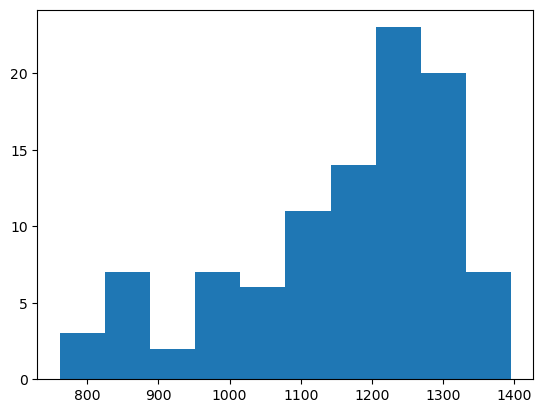

In [8]:
plt.hist(df1['MS1 results, 5% FDR'])

In [9]:
set(df1['timing'])

{'37C', '41C', '44C', '47C', '50C', '53C', '56C', '59C', '63C', '67C'}

In [10]:
set(df1['sample'])

{'K', 'T'}

In [11]:
all_timings = ['37C', '41C', '44C', '47C', '50C', '53C', '56C', '59C', '63C', '67C']

resdict = {}
for sname in ['K', 'T', ]:
    resdict[sname] = defaultdict(list)
for sname, ttime, val in df1[['sample', 'timing', 'MS1 results, 5% FDR']].values:
    resdict[sname][ttime].append(val)

In [12]:
resdict

{'K': defaultdict(list,
             {'59C': [1135.0, 969.0, 1110.0, 1157.0, 1125.0],
              '56C': [862.0, 762.0, 1078.0, 1031.0, 1191.0],
              '53C': [1212.0, 1161.0, 1121.0, 972.0, 1246.0],
              '67C': [790.0, 1138.0, 965.0, 1100.0, 1049.0],
              '44C': [1349.0, 1267.0, 1362.0, 1227.0, 1258.0],
              '50C': [1171.0, 870.0, 823.0, 1229.0, 1272.0],
              '41C': [1272.0, 1247.0, 1304.0, 1316.0, 1305.0],
              '47C': [1083.0, 975.0, 1262.0, 1020.0, 1266.0],
              '63C': [970.0, 883.0, 829.0, 1122.0, 1160.0],
              '37C': [1352.0, 1306.0, 1294.0, 1263.0, 1167.0]}),
 'T': defaultdict(list,
             {'59C': [1214.0, 1173.0, 1189.0, 1175.0, 1234.0],
              '56C': [1108.0, 1248.0, 1196.0, 908.0, 1216.0],
              '53C': [1143.0, 1241.0, 1209.0, 873.0, 981.0],
              '67C': [1149.0, 841.0, 1034.0, 887.0, 1213.0],
              '44C': [1226.0, 1313.0, 1311.0, 1178.0, 1287.0],
              '50C': [

In [13]:
all_conditions = []
all_conditions2 = []
for k, v in resdict.items():
    for kk in v.keys():
        if k == 'T':
            all_conditions.append((k, kk))
        all_conditions2.append((k, kk))

In [14]:
all_conditions, all_conditions2

([('T', '59C'),
  ('T', '56C'),
  ('T', '53C'),
  ('T', '67C'),
  ('T', '44C'),
  ('T', '50C'),
  ('T', '41C'),
  ('T', '47C'),
  ('T', '63C'),
  ('T', '37C')],
 [('K', '59C'),
  ('K', '56C'),
  ('K', '53C'),
  ('K', '67C'),
  ('K', '44C'),
  ('K', '50C'),
  ('K', '41C'),
  ('K', '47C'),
  ('K', '63C'),
  ('K', '37C'),
  ('T', '59C'),
  ('T', '56C'),
  ('T', '53C'),
  ('T', '67C'),
  ('T', '44C'),
  ('T', '50C'),
  ('T', '41C'),
  ('T', '47C'),
  ('T', '63C'),
  ('T', '37C')])

In [15]:
#Run DirectMS1Quant

s_files_dict = defaultdict(list)

for fn in listdir(ms1folder):
    if fn.endswith('_proteins_full.tsv'):
        f_name = fn.replace('.features_proteins_full.tsv', '')
        if f_name in f_dict_map:
            s_files_dict[f_dict_map[f_name]].append(path.join(ms1folder, fn))
        
for temp in ['T', 'K']:
    for tt in all_timings[1:]:
        i1 = (temp, '37C')
        i2 = (temp, tt)
        
    S_first_list = ' '.join(s_files_dict[i1])
    S_second_list = ' '.join(s_files_dict[i2])
    out_name = path.join(ms1folder, 'fulldirectms1quant_out_%s_vs_%s' % (''.join(list(i1)), ''.join(list(i2))))
    !directms1quant\
    -S1 $S_first_list\
    -S2 $S_second_list -out $out_name -fold_change 2 -d $path_to_fasta -min_samples 4 -output_peptides -qval 0.05 -all_pfms

In [16]:
def sort_columns(x):
    v = 0
    if 'T' in x:
        v += 1000
        
    x_time = x.replace('T', '').replace('K', '').replace('C', '')
        
    koef = float(x_time)
        
    v += koef
        
    return v

In [17]:
lbls = [''.join(z) for z in all_conditions]
lbls = sorted(lbls, key=sort_columns)
lbls

['T37C',
 'T41C',
 'T44C',
 'T47C',
 'T50C',
 'T53C',
 'T56C',
 'T59C',
 'T63C',
 'T67C']

In [18]:
lbls2 = [''.join(z) for z in all_conditions2]
lbls2 = sorted(lbls2, key=sort_columns)
lbls2

['K37C',
 'K41C',
 'K44C',
 'K47C',
 'K50C',
 'K53C',
 'K56C',
 'K59C',
 'K63C',
 'K67C',
 'T37C',
 'T41C',
 'T44C',
 'T47C',
 'T50C',
 'T53C',
 'T56C',
 'T59C',
 'T63C',
 'T67C']

In [34]:
df_prots = False
all_prots = set()

for temp in ['T', 'K']:
    for tt in all_timings[1:]:
        i1 = (temp, '37C')
        i2 = (temp, tt)
        out_name = path.join(ms1folder, 'fulldirectms1quant_out_%s_vs_%s.tsv' % (''.join(list(i1)), ''.join(list(i2))))
        if os.path.isfile(out_name):
            df0 = pd.read_table(out_name)


            all_prots.update(set(df0['dbname']))
        
        

for temp in ['T', 'K']:
    for tt in all_timings[1:]:
        i1 = (temp, '37C')
        i2 = (temp, tt)
        out_name = path.join(ms1folder, 'fulldirectms1quant_out_%s_vs_%s.tsv' % (''.join(list(i1)), ''.join(list(i2))))
        if os.path.isfile(out_name):
            df0_full = pd.read_table(out_name.replace('.tsv', '_quant_full.tsv'))
            df0_full = df0_full[df0_full['dbname'].apply(lambda x: x in all_prots)]

            lbl_c = ''.join(list(i2))


            df0_full.loc[df0_full['v_arr'] <= 2, 'FC'] = df0_full.loc[df0_full['v_arr'] <= 2, 'FC_basic_raw']


            df0_full = df0_full[['dbname', 'FC', 'BH_pass', 'score']]
            df0_full = df0_full.rename(columns={'FC': lbl_c, 'BH_pass': 'BH_pass_'+lbl_c})

            if df_prots is False:
                df_prots = df0_full
            else:
                df_prots = df_prots.merge(df0_full, on='dbname', how='outer')
                df_prots['score'] = df_prots['score_x'] + df_prots['score_y']
                df_prots = df_prots.drop(columns=['score_x', 'score_y'])
                


df_prots['K37C'] = 0.0
df_prots['T37C'] = 0.0
df_prots['BH_pass_K37C'] = True            
df_prots['BH_pass_T37C'] = True            
            
cc_BH = [cc for cc in df_prots.columns if 'BH_pass' in cc]

df_prots['score'] = df_prots[cc_BH].sum(axis=1)

df_prots = df_prots.sort_values(by='score', ascending=False)

In [35]:
resdict = {}
resdict2 = {}
for z in df_prots[['dbname'] + [lbl for lbl in lbls2 if lbl in df_prots.columns]].values:
    resdict[z[0]] = z[1:]
    
    
for z in df_prots[['dbname'] + ['BH_pass_'+lbl for lbl in lbls2 if lbl in df_prots.columns]].values:
    resdict2[z[0]] = [(resdict[z[0]][idx] if cc is True else 0) for idx, cc in enumerate(z[1:])]

In [33]:
plt.close('all')

In [23]:
def func(x, a,b):
    x=np.array(x)
    return (1/(1+np.exp(abs(a)-((abs(a)*b)/x))))

In [ ]:
# OLD FORMULA

In [173]:
#Approximating solubility curves

names=[]
coefsT = pd.DataFrame(columns=[ 'a', 'b'])
coefsK = pd.DataFrame(columns=[ 'a', 'b'])
norm_flag = 1

for dbname in list(resdict.keys()):
        all_y = defaultdict(list)
        all_y2 = defaultdict(list)
        all_x = defaultdict(list)
        all_x2 = defaultdict(list)                                                      

        y_val_max = 0
        y_val_min = 0

        for lbl, yval, yval2 in zip(lbls2, resdict[dbname], resdict2[dbname]):

     

            sample = ('K' if 'K' in lbl else 'T')
            timing = float(lbl.replace('T', '').replace('K', '').replace('C', ''))

            all_x[sample].append(timing+273)
            all_y[sample].append(yval)

            if y_val_max < yval:
                y_val_max = yval
            if y_val_min > yval:
                y_val_min = yval


            if yval2 != 0:
                all_x2[sample].append(timing+273)
                all_y2[sample].append(yval2)

        if 1:
            
            for sample in ['T']:
                loh1 = np.array(all_y[sample])
                t = loh1-loh1[-1] 
                y = t/t[0]
                for i in range(len(y)):
                    if y[i]>1:
                        y[i]=1
                    elif y[i]<0:
                        y[i]=0
                        
                try:
                    popt, pcov = optimize.curve_fit(func, np.array(all_x[sample]), y, p0=[200, 325], method='lm', maxfev=10000) 
                    perr = np.sqrt(np.diag(pcov))
                    perr1 = np.sqrt(np.power(perr[0],2)+np.power(perr[1], 2))# аппроксимация и добавление в датафрейм по treatment
                    coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
                except:
                     pass
                
                
            for sample in ['K']:
                
                l2 = np.array(all_y[sample])                 
                t1 = l2-l2[-1]  
                y1 = t1/t1[0]
                for i in range(len(y1)):
                    if y1[i]>1:
                        y1[i]=1
                    elif y1[i]<0:
                        y1[i]=0
                try:
                    popt2, pcov2 = optimize.curve_fit(func, np.array(all_x[sample]), y1, p0=[200, 325], method='lm', maxfev=10000)
                    perr2 = np.sqrt(np.diag(pcov2))
                    perr22 = np.sqrt(np.power(perr2[0],2)+np.power(perr2[1], 2))
                    coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
                except:
                    pass



/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecate

/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecate

/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecate

/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsT=coefsT.append({'dbname': dbname, 'a':popt[0], 'b':popt[1],'y_val':y, 'y_val_without': loh1, 'perr': perr1}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsK=coefsK.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2}, ignore_index=True)
/tmp/ipykernel_85210/1242538358.py:53: FutureWarning: The frame.append method is deprecated and will be 

[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329.0, 332.0, 336.0, 340.0]

In [274]:
#Finding R^2

diff = coefsT.merge(coefsK, how='inner', on='dbname', suffixes=('_T', '_K'))

x_difT=[]
for i in range(len(diff)):
    x_timedT=[]
    for j in range(len(all_x[sample])):
        x_timedT.append(all_x[sample][j])
    x_difT.append(x_timedT)

#########
#########

qu_difT=[]
for i in range(len(diff)):
    qu_timedT=[]
    for j in range(len(all_x[sample])):
        qu_timedT.append(func(all_x[sample][j], diff['a_T'][i], diff['b_T'][i]))
    qu_difT.append(qu_timedT)
    
qu_difK=[]
for i in range(len(diff)):
    qu_timedK=[]
    for j in range(len(all_x[sample])):
        qu_timedK.append(func(all_x[sample][j], diff['a_K'][i], diff['b_K'][i]))     
    qu_difK.append(qu_timedK)
        
#########
#########

diff['x_val'] = x_difT
diff['func_val_T'] = qu_difT
diff['func_val_K'] = qu_difK

#########
#########

r2_T=[]
r2_K =[]

for i in range(len(diff)):
    r2_T.append(r2_score(list(diff['y_val_T'][i]), list(diff['func_val_T'][i])))
    r2_K.append(r2_score(list(diff['y_val_K'][i]), list(diff['func_val_K'][i])))

diff['r2_T'] = r2_T
diff['r2_K'] = r2_K
diff['r2'] = (diff['r2_T']+diff['r2_K'])/2

# ########
# ########

diff['difference'] = diff['b_T']-diff['b_K']


#########
#########


diff = diff.sort_values(['difference'])

diff['nicer2']=diff.apply(lambda x: x['r2_T']>0.8, axis=1)
diff['nicer']=diff.apply(lambda x: x['r2_K']>0.8, axis=1)
diff=diff[diff['nicer']]
diff=diff[diff['nicer2']]

In [275]:
diff

,a_T,b_T,dbname,y_val_T,y_val_without_T,perr,a_K,b_K,y_val_K,y_val_without_K,x_val,func_val_T,func_val_K,r2_T,r2_K,r2,difference,nicer2,nicer
174,83.530391,326.387678,sp|P50583|AP4A_HUMAN,"[1.0, 0.9979073602857429, 0.9401583734435723, ...","[0.0, -0.0052583969843961, -0.1503703798039538...",27.707189,549.288230,336.910383,"[1.0, 0.9788520136020212, 0.9747397251027408, ...","[0.0, -0.2202510944204566, -0.2630795711129569...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9880583186786245, 0.9642697825786849, 0.922...","[1.0, 1.0, 0.9999999999999989, 0.9999999999997...",0.851170,0.876334,0.863752,-10.522706,True,True
95,-79.278532,327.121556,sp|P33991|MCM4_HUMAN,"[1.0, 1.0, 1.0, 0.9537451977108128, 0.56562952...","[0.0, 0.0602621357476125, 0.0320530937130969, ...",16.067106,-567.336554,336.891309,"[1.0, 0.9917780603422265, 0.9376610400423668, ...","[0.0, -0.0856294861271822, -0.6492449870789565...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9876126992006878, 0.9648694813671856, 0.926...","[1.0, 1.0, 0.9999999999999996, 0.9999999999999...",0.941182,0.934421,0.937801,-9.769753,True,True
153,73.155681,327.543925,sp|Q96RP9|EFGM_HUMAN,"[1.0, 1.0, 0.9828379796561223, 0.9812923488143...","[0.0, 0.0029077523520722, -0.0392447943691902,...",16.394123,-544.323504,336.841320,"[1.0, 0.9849238853276792, 0.9706190049888456, ...","[0.0, -0.1570140387693989, -0.3059958610048676...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9843285904495307, 0.9591233957660764, 0.919...","[1.0, 1.0, 0.9999999999999984, 0.9999999999996...",0.917722,0.920122,0.918922,-9.297395,True,True
154,-91.536104,327.724517,sp|P50897|PPT1_HUMAN,"[1.0, 0.9963181205869268, 0.987375625686378, 0...","[0.0, -0.0072800693696252, -0.0249617954420103...",16.011804,644.364953,336.910491,"[1.0, 0.9661093191536462, 0.9792122076753962, ...","[0.0, -0.352963133538672, -0.2164997614390717,...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9946943093334721, 0.9820300276433576, 0.956...","[1.0, 1.0, 1.0, 0.9999999999999984, 0.99999999...",0.961880,0.935254,0.948567,-9.185974,True,True
130,107.302622,328.340360,sp|O95861|BPNT1_HUMAN,"[1.0, 0.9948254699492872, 1.0, 1.0, 0.73569115...","[0.0, -0.0108162301759258, 0.0764745621067658,...",12.923227,621.557197,336.904563,"[1.0, 0.9916994648215199, 0.9913788725144473, ...","[0.0, -0.0864480392095608, -0.0897869295023146...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9982533127136094, 0.9926121539262436, 0.978...","[1.0, 1.0, 1.0, 0.9999999999999944, 0.99999999...",0.984686,0.968123,0.976404,-8.564203,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,467.690514,336.834827,sp|Q15257|PTPA_HUMAN,"[1.0, 1.0, 0.9910547690036433, 1.0, 0.95616669...","[0.0, 0.0610069705933823, -0.0783262193588344,...",370.857114,-240.862459,330.392429,"[1.0, 0.961371595410177, 0.9522432891810036, 0...","[0.0, -0.0664119418067553, -0.0821057958119456...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[1.0, 0.9999999999999982, 0.9999999999998046, ...","[0.9999998685213212, 0.9999965401077957, 0.999...",0.972118,0.970746,0.971432,6.442398,True,True
131,-64.050637,329.488850,sp|P49327|FAS_HUMAN,"[1.0, 1.0, 1.0, 1.0, 0.543640788556485, 0.7093...","[0.0, 0.0766851959652226, 0.0193025064279881, ...",14.752228,139.312446,321.551417,"[1.0, 0.8762991526409081, 0.8412076057591941, ...","[0.0, -0.2046023995892796, -0.2626441579974177...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9824791551714436, 0.9592798878668553, 0.925...","[0.9944651948234451, 0.9661159222030768, 0.880...",0.898171,0.989352,0.943761,7.937433,True,True
235,248.441173,336.727176,sp|O15305|PMM2_HUMAN,"[1.0, 1.0, 0.9944125983694744, 1.0, 0.92257998...","[0.0, 0.0306013039235668, -0.0489243984796704,...",108.768319,-135.094583,328.766894,"[1.0, 0.9574402289658949, 0.9165858409291014, ...","[0.0, -0.0890210381299304, -0.1744749761288909...","[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.999

In [276]:
def noisygaus(x, a, x0, sigma, b):
    return a * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)) + b

In [280]:
#normal distribution

H1, b1 = np.histogram(diff['difference'], bins=26)
b1 = b1[:-1]
popt, pcov = optimize.curve_fit(noisygaus, b1, H1, p0=[1, np.median(diff['difference']), 2, 1])
segma = popt[3]
x_width = popt[2]
segma, x_width

(2.1868677623161594, -1.2060697632798056)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


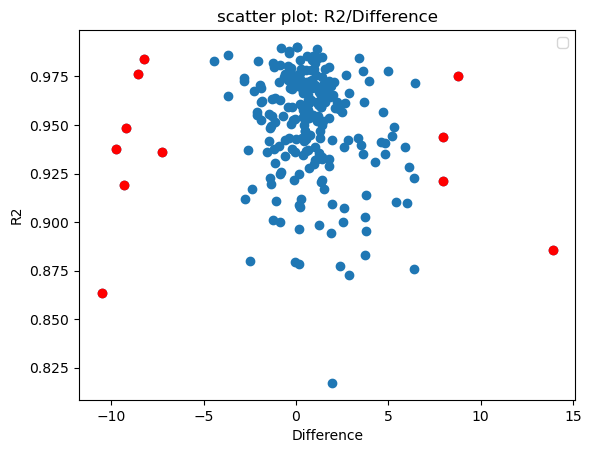

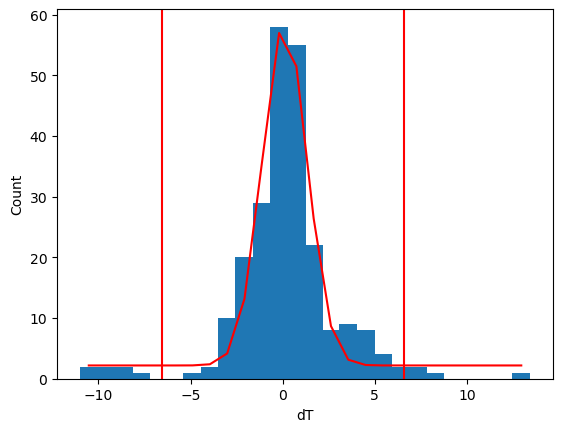

In [281]:
#Finding sigma and targets

########
########

plt.scatter(diff['difference'], diff['r2'])
plt.xlabel('Difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/Difference')
       # scatter для значений rms и difference

    
diff1 = diff.dropna()
diff1['nice']=diff1.apply(lambda x: abs(x['difference'])>3*segma, axis=1)
diff1=diff1[diff1['nice']]
diff1 = diff1.sort_values(['r2'])
diff1 = diff1.reset_index(drop=True)
plt.scatter(diff1['difference'], diff1['r2'], color = 'red')
plt.xlabel('Difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/Difference')
plt.show()             
    


plt.bar(b1, H1, alpha=1, width=1)
plt.plot(b1, noisygaus(b1, popt[0], popt[1], popt[2], popt[3]), color = 'red')
plt.axvline(x=3*segma, color = 'red')
plt.axvline(x=-3*segma, color = 'red')
# plt.axvline(x=segma, color = 'red')
# plt.axvline(x=-segma, color = 'red')
plt.xlabel('dT')
plt.ylabel('Count')
plt.show()


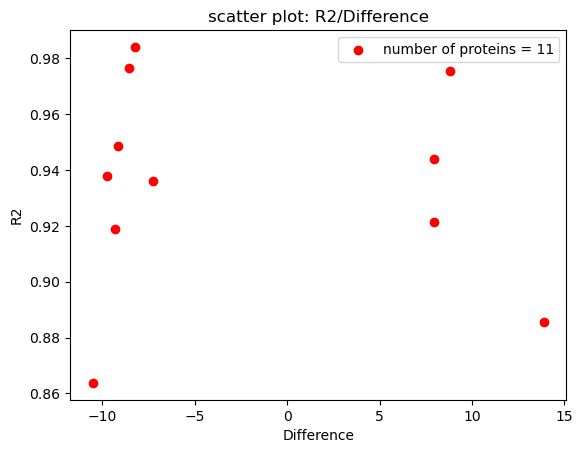

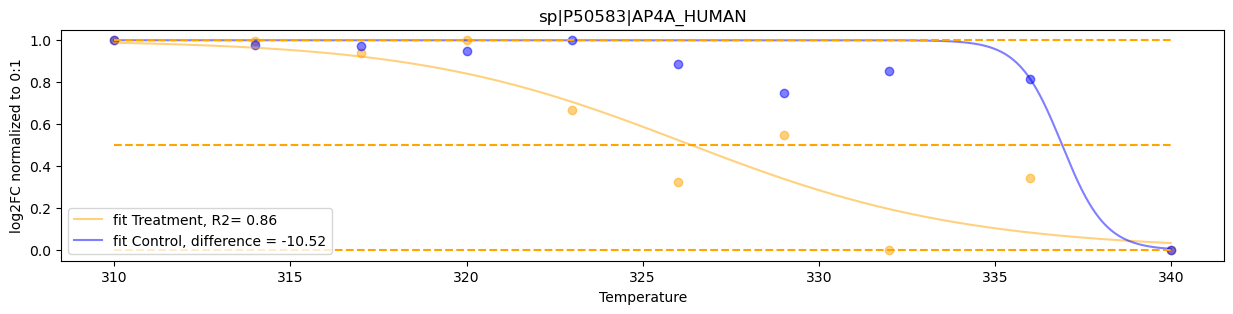

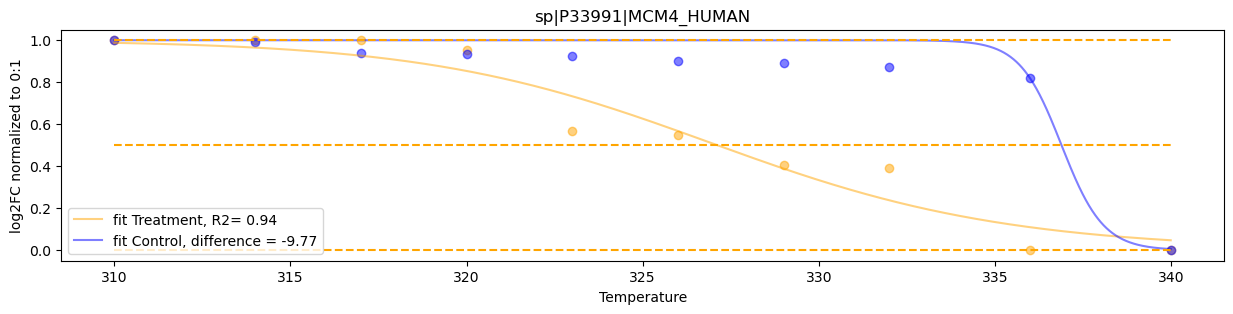

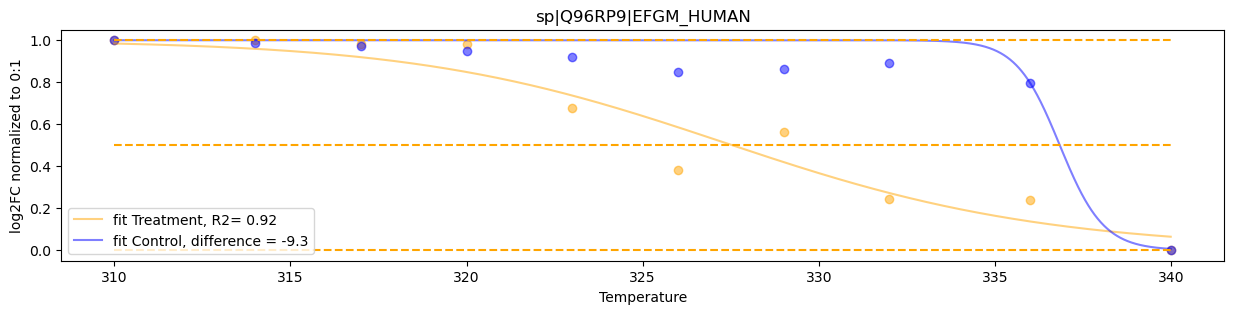

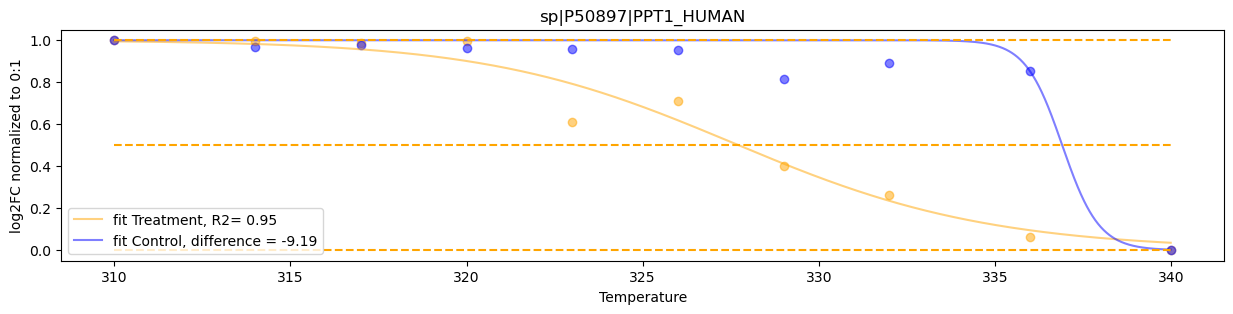

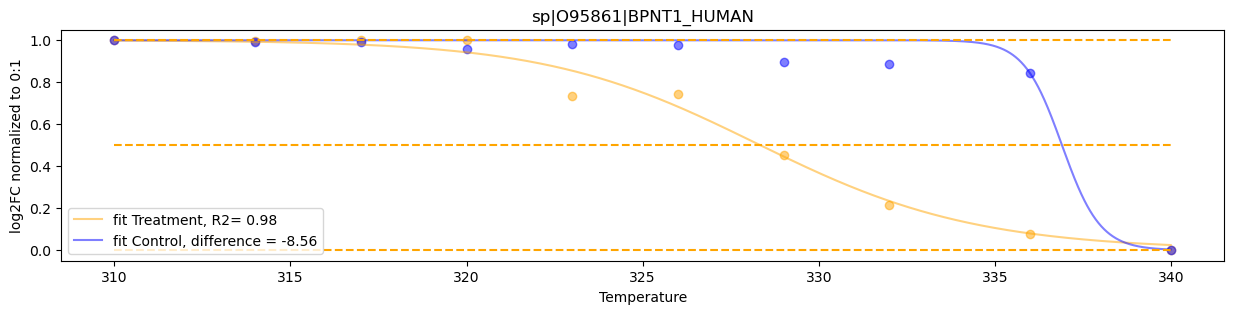

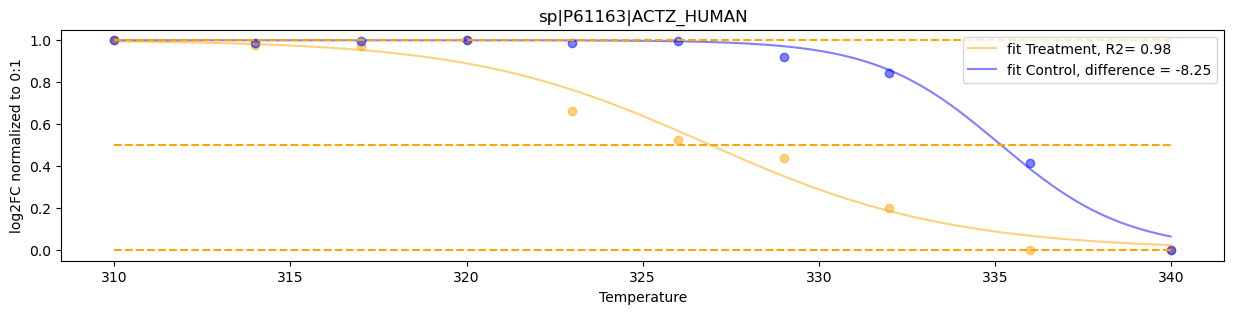

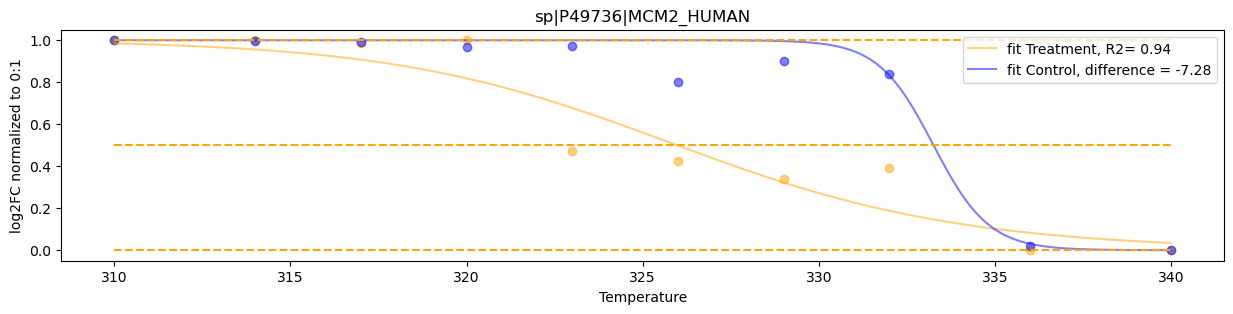

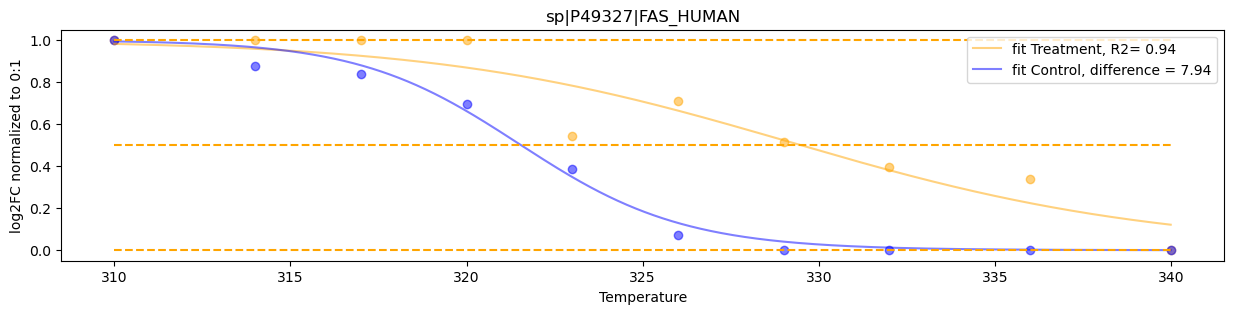

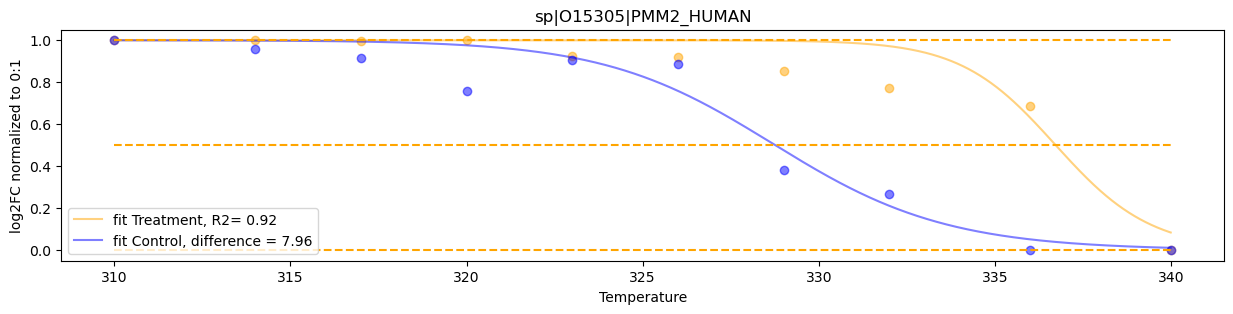

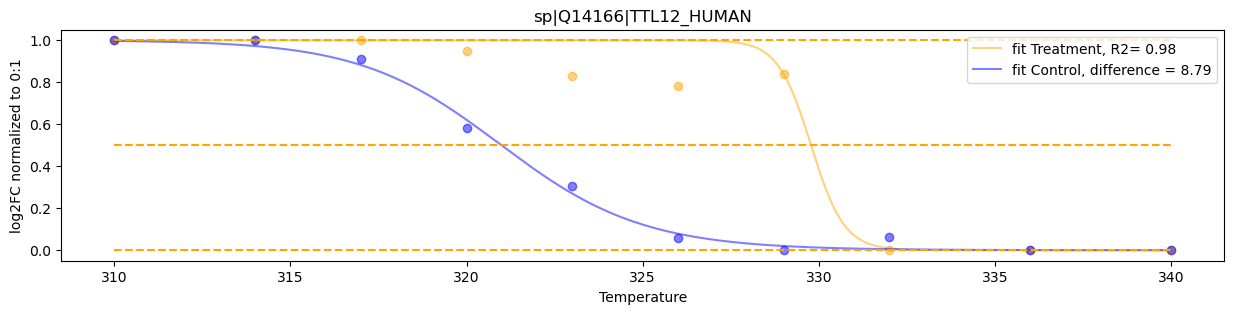

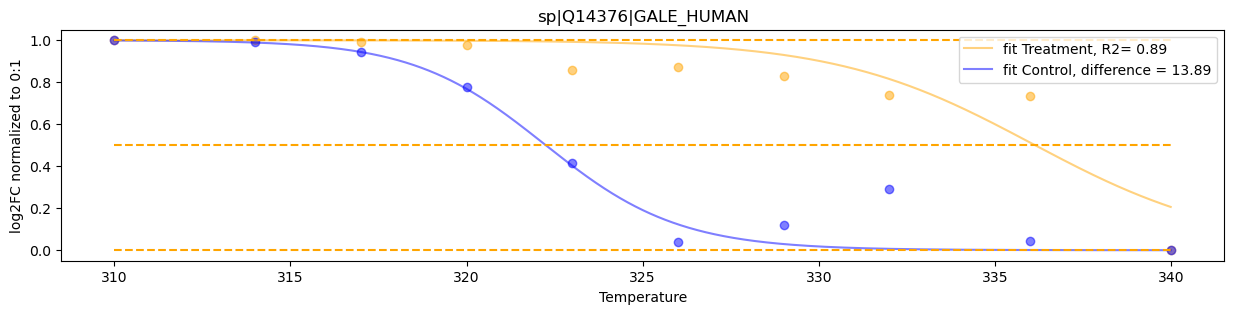

In [282]:
#Plot solubility curves for targets

# #########
# #########

diff = diff.dropna()
diff['nice']=diff.apply(lambda x: abs(x['difference'])>3*segma, axis=1)
diff1=diff[diff['nice']]
diff1 = diff1.sort_values(['r2'])
diff1 = diff1.reset_index(drop=True)
plt.scatter(diff1['difference'], diff1['r2'], label= f'number of proteins = {len(diff1)}', color='red')
plt.xlabel('Difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/Difference')

plt.show()         

#########
#########
diff1=diff1.sort_values(['difference'])
diff1 = diff1.reset_index(drop=True)

for i in range(len(diff1)):
        plt.figure(figsize=(15,3))
        plt.scatter(diff1['x_val'][i], diff1['y_val_T'][i],color='orange', alpha=0.5)
        plt.scatter(diff1['x_val'][i], diff1['y_val_K'][i],color='b', alpha=0.5)
        plt.plot(np.arange(310, 340, 0.01), func(np.arange(310, 340, 0.01), diff1['a_T'][i], diff1['b_T'][i]), color = 'orange',label = f"fit Treatment, R2= {round(diff1['r2'][i], 2)}", alpha=0.5)
        plt.plot(np.arange(310, 340, 0.01), func(np.arange(310, 340, 0.01), diff1['a_K'][i], diff1['b_K'][i]), color='b',label = f"fit Control, difference = {round(diff1['difference'][i], 2)}", alpha=0.5)
        plt.hlines(0, 310, 340, color='orange', linestyles='--')
        plt.hlines(1, 310, 340, color='orange', linestyles='--')
        plt.hlines(0.5, 310, 340, color='orange', linestyles='--')
        plt.xlabel('Temperature')
        plt.legend()                                                       # строю графики этих белков
        plt.title(diff1['dbname'][i])
        plt.ylabel('log2FC normalized to 0:1')
        plt.show()
        

In [ ]:
# END OF OLD FORMULA

In [ ]:
# NEW FORMULA

In [157]:
#Fitting solubility curves

names=[]
coefsTT = pd.DataFrame(columns=['l', 't', 'k'])                   #три строчки - мои
coefsCC = pd.DataFrame(columns=['a', 'b'])
norm_flag = 1

for dbname in list(resdict.keys()):
        all_y = defaultdict(list)
        all_y2 = defaultdict(list)
        all_x = defaultdict(list)
        all_x2 = defaultdict(list)                                                      

        y_val_max = 0
        y_val_min = 0                                                                #КОД МАРКА

        for lbl, yval, yval2 in zip(lbls2, resdict[dbname], resdict2[dbname]):

     

            sample = ('K' if 'K' in lbl else 'T')
            timing = float(lbl.replace('T', '').replace('K', '').replace('C', ''))

            all_x[sample].append(timing + 273)
            all_y[sample].append(yval)

            if y_val_max < yval:
                y_val_max = yval
            if y_val_min > yval:
                y_val_min = yval


            if yval2 != 0:
                all_x2[sample].append(timing+273)
                all_y2[sample].append(yval2)

        if 1:                                                                #КОД МАРКА
            


                
                
            for sample in ['K']:
                
                l2 = np.array(all_y[sample])                 
                t1 = l2-l2[-1]  
                y1 = t1/t1[0]
                for i in range(len(y1)):
                    if y1[i]>1:
                        y1[i]=1
                    elif y1[i]<0:
                        y1[i]=0
                try:
                    popt2, pcov2 = optimize.curve_fit(func, np.array(all_x[sample]), 
                                                      y1, p0=[70, 320], bounds = ([10, 298], [600, 340]),
                                                      method='trf')
                    perr2 = np.sqrt(np.diag(pcov2))
                    perr22 = np.sqrt(np.power(perr2[0],2)+np.power(perr2[1], 2))
                    coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
                                         'perr_a': perr2[0], 'perr_b': perr2[1],}, 
                                         ignore_index=True)
                except:
                    pass
        
        
            for sample in ['T']:
                def func_new(x, l, t, k, a = popt2[0], b = popt2[1]):
                    x=np.array(x)
                    return (((1-k)/(1+np.exp((a-(a*b)/x))))+((k)/(1+np.exp((l-(b*l)/x-(t*l)/x)))))
                
                loh1 = np.array(all_y[sample])
                t = loh1-loh1[-1] 
                y = t/t[0]
                for i in range(len(y)):
                    if y[i]>1:
                        y[i]=1
                    elif y[i]<0:
                        y[i]=0
                try:
                    popt, pcov = optimize.curve_fit(func_new, 
                                                    np.array(all_x[sample]), 
                                                    y,
                                                    p0 = [70, 0, 0],
                                                    bounds = ([10, -25, 0], [600, 25, 1]),
                                                    method='trf',
                                                    maxfev=100000) 
                    perr = np.sqrt(np.diag(pcov))
                    perr1 = np.sqrt(np.power(perr[0],2)+np.power(perr[1], 2))
                    coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0], 
                                          't':popt[1],'k':popt[2],'y_val':y, 'y_val_without': loh1,
                                          'perr_l': perr[0], 'perr_t': perr[1], 'perr_k': perr[2]}, ignore_index=True)
#                    




                except:
                     print('не зафиттил')

/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':pop

/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':pop

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':pop

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without': l2,
/tmp/ipykernel_85210/494962645.py:89: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsTT=coefsTT.append({'dbname': dbname, 'l':popt[0],
/tmp/ipykernel_85210/494962645.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  coefsCC=coefsCC.append({'dbname': dbname, 'a':popt2[0], 'b':popt2[1],'y_val':y1, 'y_val_without'

In [264]:
#Finding R^2 and k

difff = coefsTT.merge(coefsCC, how='inner', on='dbname', suffixes=('_T', '_K'))

x_difT=[]
for i in range(len(difff)):
    x_timedT=[]
    for j in range(len(all_x[sample])):
        x_timedT.append(all_x[sample][j])
    x_difT.append(x_timedT)

#########
#########

qu_difT=[]
for i in range(len(difff)):
    qu_timedT=[]
    for j in range(len(all_x[sample])):
        qu_timedT.append(func_new(all_x[sample][j], difff['l'][i], difff['t'][i],
                                  difff['k'][i], difff['a'][i], difff['b'][i]))

    qu_difT.append(qu_timedT)
    
qu_difC=[]
for i in range(len(difff)):
    qu_timedC=[]
    for j in range(len(all_x[sample])):
        qu_timedC.append(func(all_x[sample][j], difff['a'][i], difff['b'][i]))
        
    qu_difC.append(qu_timedC)
        
#########
#########

difff['x_val'] = x_difT
difff['func_val_T'] = qu_difT
difff['func_val_K'] = qu_difC

#######
#######
r2_T=[]
r2_K =[]
for i in range(len(difff)):
    r2_T.append(r2_score(list(difff['y_val_T'][i]), list(difff['func_val_T'][i])))
    r2_K.append(r2_score(list(difff['y_val_K'][i]), list(difff['func_val_K'][i])))

difff['r2_T'] = r2_T
difff['r2_K'] = r2_K
difff['r2'] = (difff['r2_T']+difff['r2_K'])/2

# ########
# ########

difff['difference'] = difff['t']

#########

#########

difff = difff.sort_values(['difference'])

difff['nicer2']=difff.apply(lambda x: x['r2_T']>0.8, axis=1)
difff['nicer']=difff.apply(lambda x: x['r2_K']>0.8, axis=1)
difff['nicer3']=difff.apply(lambda x: x['k']>0.5, axis=1)

difff=difff[difff['nicer']]
difff=difff[difff['nicer2']]
difff=difff[difff['nicer3']]


In [265]:
difff

,l,t,k,dbname,y_val_T,y_val_without_T,perr_l,perr_t,perr_k,a,...,x_val,func_val_T,func_val_K,r2_T,r2_K,r2,difference,nicer2,nicer,nicer3
153,364.346643,-13.899683,0.625913,sp|Q96RP9|EFGM_HUMAN,"[1.0, 1.0, 0.9828379796561223, 0.9812923488143...","[0.0, 0.0029077523520722, -0.0392447943691902,...",371.247729,0.532255,0.052482,544.324580,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9999998448696517, 0.9999804768334775, 0.999...","[1.0, 1.0, 0.9999999999999984, 0.9999999999996...",0.955654,0.920122,0.937888,-13.899683,True,True,True
174,394.159907,-13.842468,0.691703,sp|P50583|AP4A_HUMAN,"[1.0, 0.9979073602857429, 0.9401583734435723, ...","[0.0, -0.0052583969843961, -0.1503703798039538...",748.049358,0.781315,0.089713,549.286265,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9999999579430608, 0.9999921220529634, 0.999...","[1.0, 1.0, 0.9999999999999989, 0.9999999999997...",0.887962,0.876334,0.882148,-13.842468,True,True,True
80,600.000000,-11.318728,0.595597,sp|P49736|MCM2_HUMAN,"[1.0, 1.0, 0.9856244279336307, 1.0, 0.47341796...","[0.0, 0.002521507609246, -0.0269661687404401, ...",246.879502,0.470383,0.020449,423.835429,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9999999999450204, 0.9999998460298432, 0.999...","[0.9999999999999845, 0.9999999999948537, 0.999...",0.994767,0.963998,0.979382,-11.318728,True,True,True
95,87.274597,-10.780980,0.908626,sp|P33991|MCM4_HUMAN,"[1.0, 1.0, 1.0, 0.9537451977108128, 0.56562952...","[0.0, 0.0602621357476125, 0.0320530937130969, ...",34.584717,2.468375,0.209941,567.347630,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9903619643842932, 0.9696743961789178, 0.931...","[1.0, 1.0, 0.9999999999999996, 0.9999999999999...",0.942420,0.934421,0.938420,-10.780980,True,True,True
201,111.036039,-9.467894,0.859799,sp|P61163|ACTZ_HUMAN,"[1.0, 0.9771308427176877, 0.9723667439827242, ...","[0.0, -0.042479711470378, -0.0513290773293539,...",40.270916,1.847063,0.197488,187.861746,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9969169110663058, 0.9865373304221212, 0.961...","[0.9999997637145818, 0.9999968581938405, 0.999...",0.976880,0.992345,0.984613,-9.467894,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,600.000000,7.856104,0.699959,sp|P06396|GELS_HUMAN,"[1.0, 1.0, 1.0, 1.0, 0.6131677998514223, 0.803...","[0.0, 0.0726657951186413, 0.1016051590709561, ...",3325.313065,0.633250,0.114957,64.047836,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9722767244551658, 0.9425144545064463, 0.908...","[0.9076016465636854, 0.8084075692507655, 0.694...",0.957939,0.812470,0.885204,7.856104,True,True,True
235,600.000000,8.771168,0.709397,sp|O15305|PMM2_HUMAN,"[1.0, 1.0, 0.9944125983694744, 1.0, 0.92257998...","[0.0, 0.0306013039235668, -0.0489243984796704,...",212.359018,0.577624,0.021925,135.095365,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9999184692750496, 0.9994949460411835, 0.998...","[0.9997194432406525, 0.9982620502630489, 0.993...",0.996167,0.940793,0.968480,8.771168,True,True,True
9,599.999997,9.570861,0.813597,sp|Q14166|TTL12_HUMAN,"[1.0, 1.0, 1.0, 0.9504283321196139, 0.82797769...","[0.0, 0.0762689106596965, 0.025509511223006, -...",159.768843,0.404149,0.033767,159.841795,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9993572535913442, 0.9948358556203956, 0.978...","[0.9965518535316849, 0.9722958760024907, 0.882...",0.993266,0.994998,0.994132,9.570861,True,True,True
72,600.000000,15.080958,0.799427,sp|Q14376|GALE_HUMAN,"[1.0, 0.9998617394747404, 0.9918165316713974, ...","[0.0, -0.0012106366212961, -0.0716560741341685...",405.080264,0.920941,0.019006,170.570735,...,"[310.0, 314.0, 317.0, 320.0, 323.0, 326.0, 329...","[0.9997633237996002, 0.9977574278139337, 0.988...","[0.9988199969437581, 0.9888191460360966, 0.944...",0.990254,0.938814,0.964534,15.080958,True,True,True


In [270]:
#Normal distribution

H1, b1 = np.histogram(difff['difference'], bins=22)
b1 = b1[:-1]
popt, pcov = optimize.curve_fit(noisygaus, b1, H1, p0=[1, np.median(difff['difference']), 2, 1])
segma = popt[3]
x_width = popt[2]
print(segma)

1.535848636688924


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


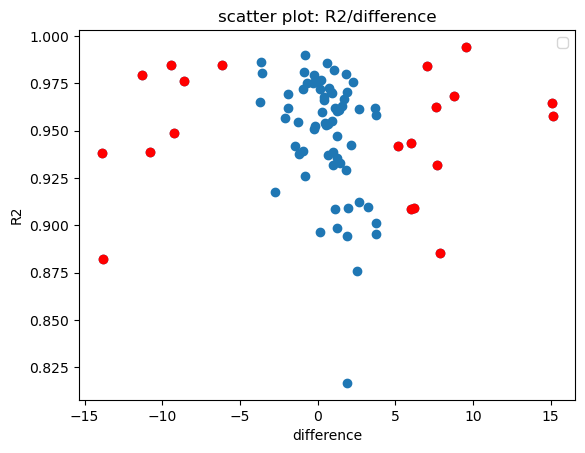

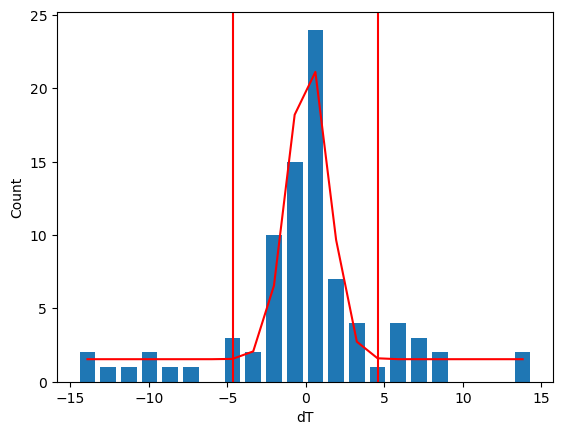

In [271]:
#Finding sigma and targets

########
########

plt.scatter(difff['difference'], difff['r2'])
plt.xlabel('difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/difference')
       # scatter для значений rms и difference

    
difff1 = difff.dropna()
difff1['nice']=difff1.apply(lambda x: abs(x['difference'])>3*segma, axis=1)
difff1=difff1[difff1['nice']]
difff1 = difff1.sort_values(['r2'])
difff1 = difff1.reset_index(drop=True)
plt.scatter(difff1['difference'], difff1['r2'], color = 'red')
plt.xlabel('difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/difference')
plt.show()             
    


plt.bar(b1, H1, alpha=1, width=1)
plt.plot(b1, noisygaus(b1, popt[0], popt[1], popt[2], popt[3]), color = 'red')
plt.axvline(x=3*segma, color = 'red')
plt.axvline(x=-3*segma, color = 'red')
# plt.axvline(x=segma, color = 'red')
# plt.axvline(x=-segma, color = 'red')
plt.xlabel('dT')
plt.ylabel('Count')
plt.show()

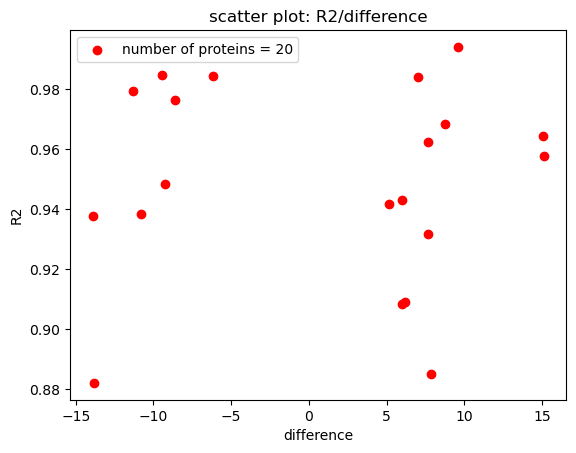

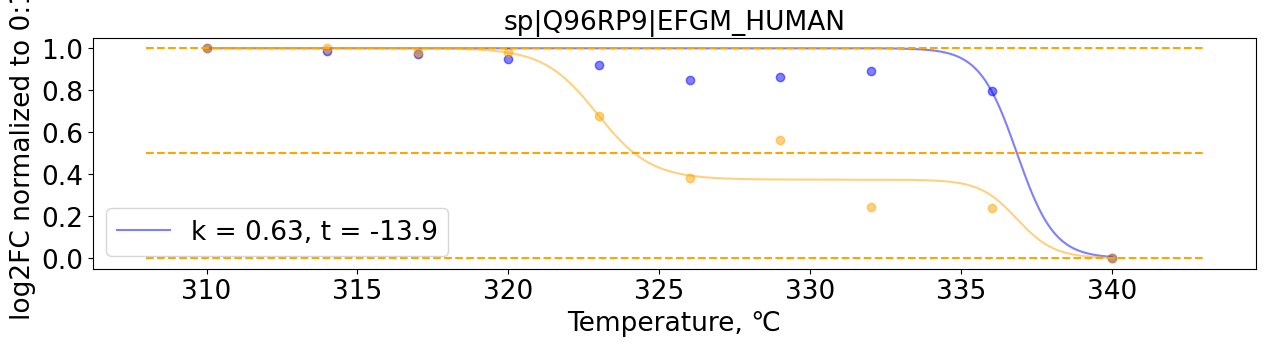

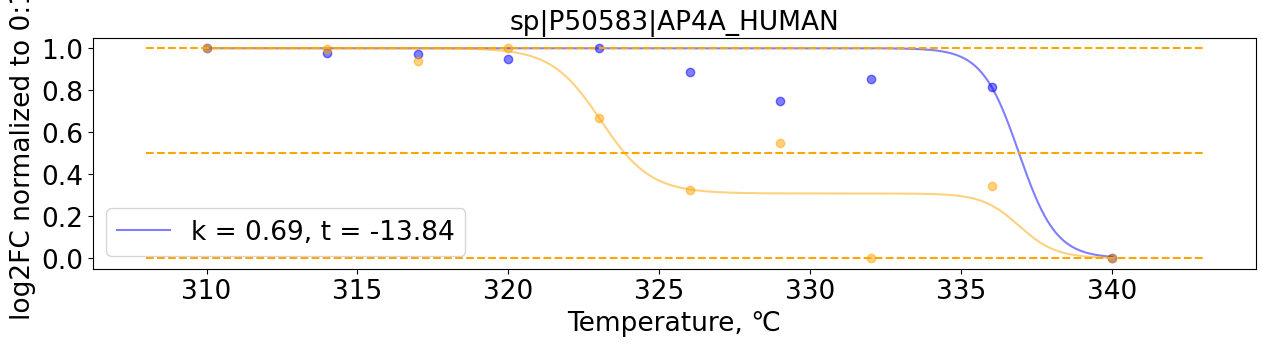

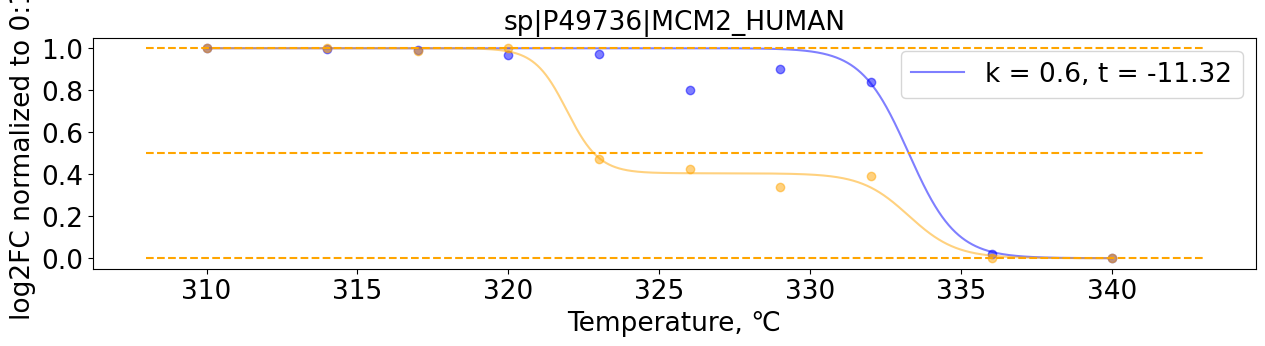

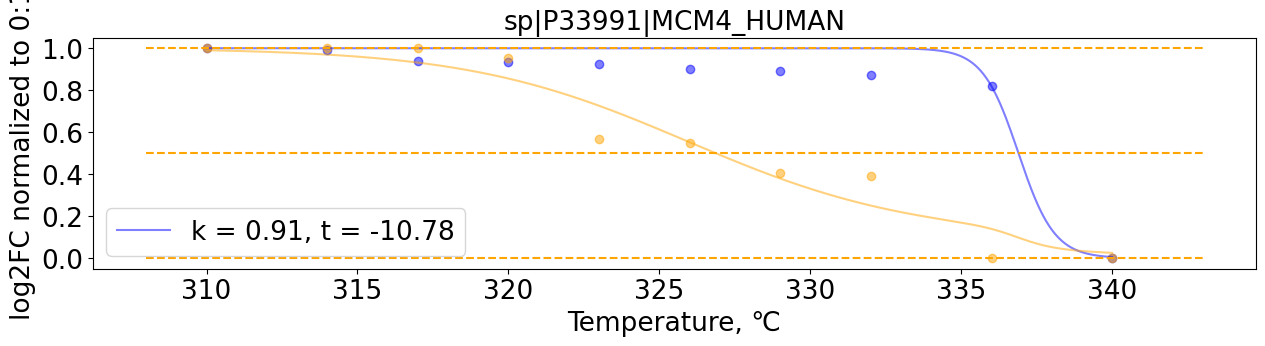

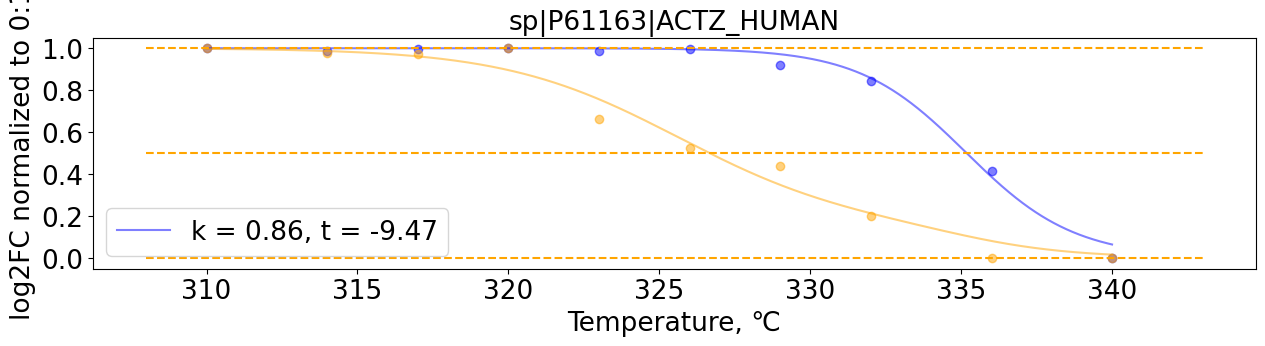

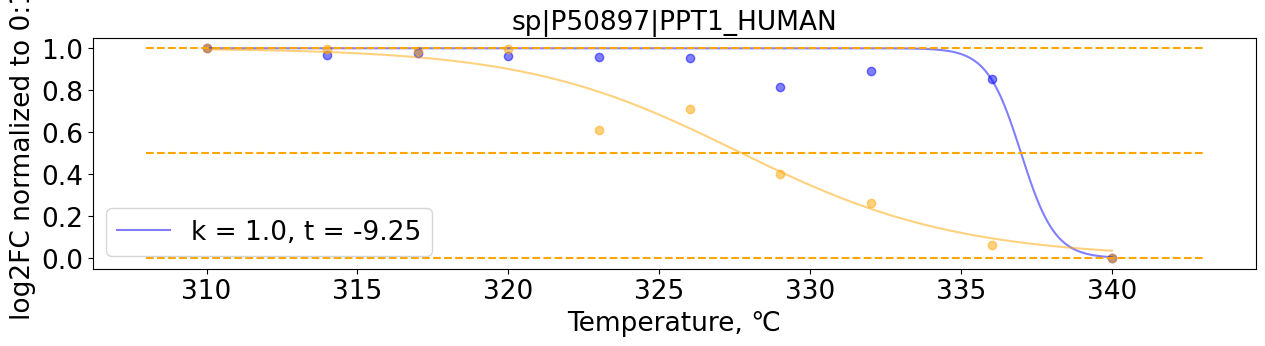

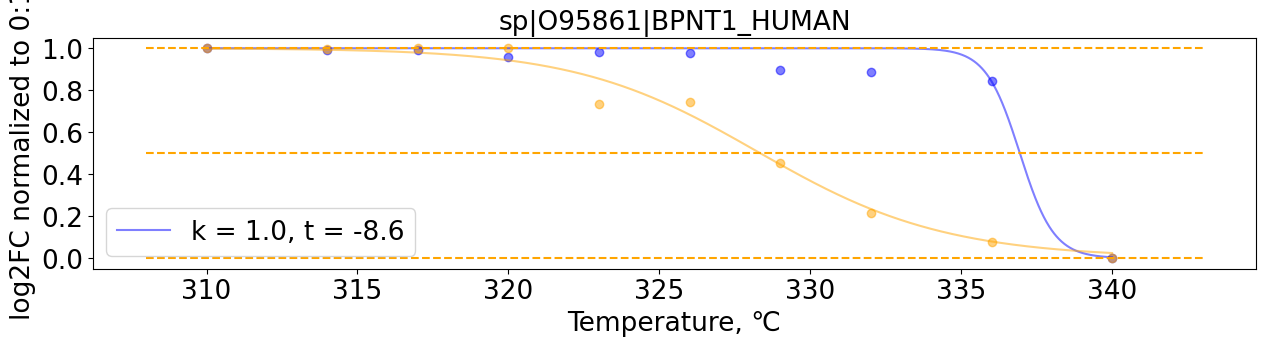

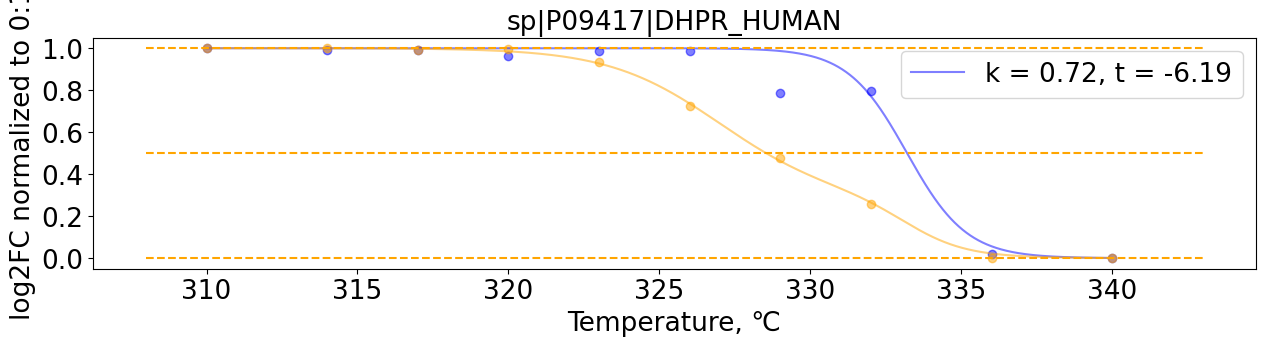

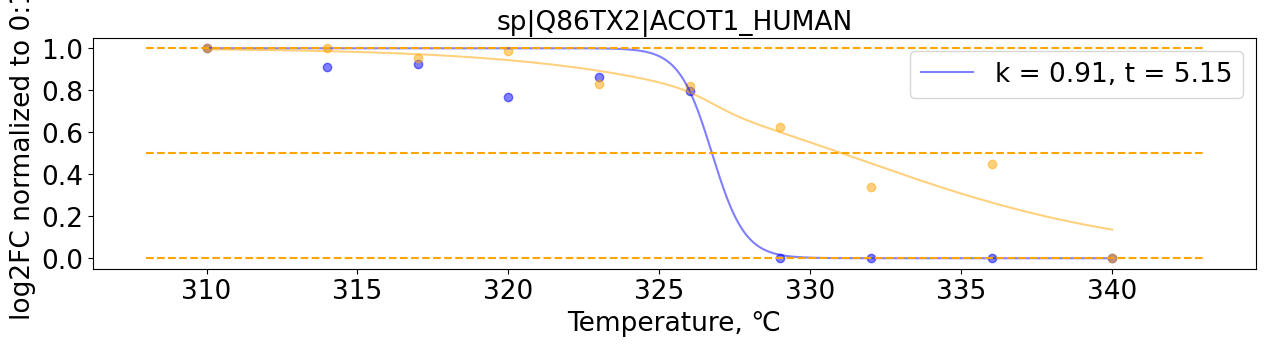

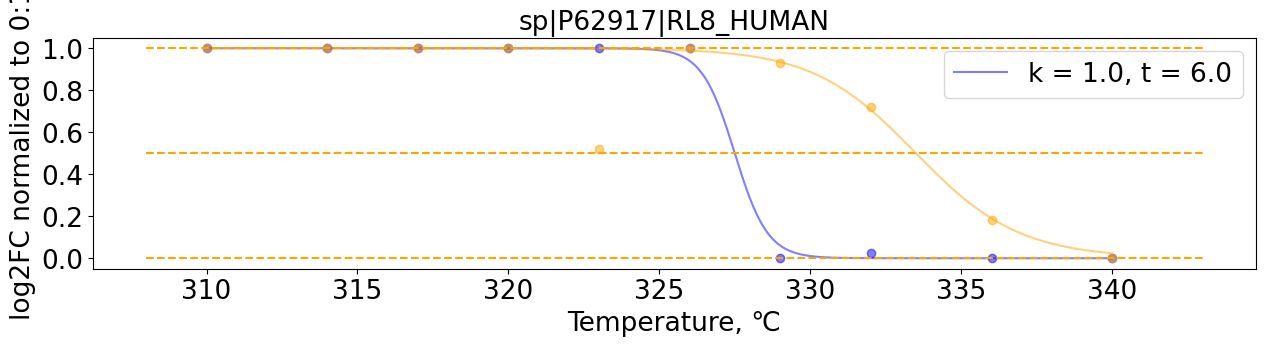

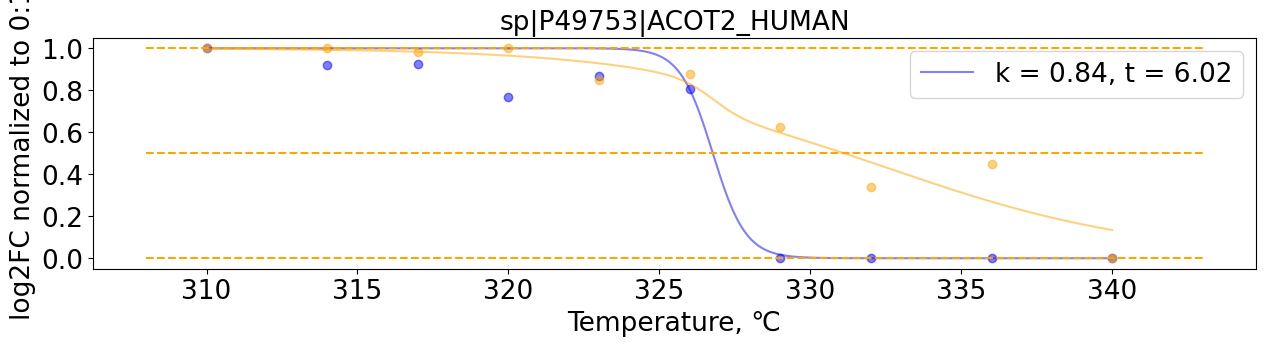

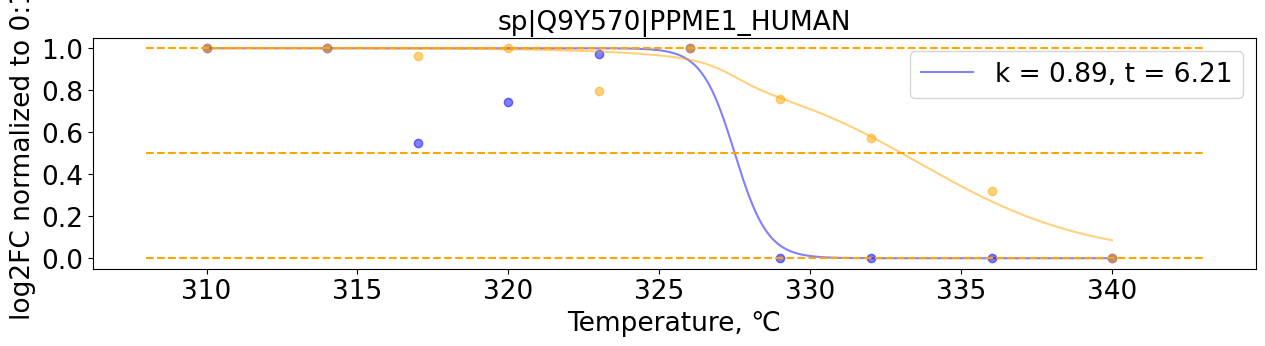

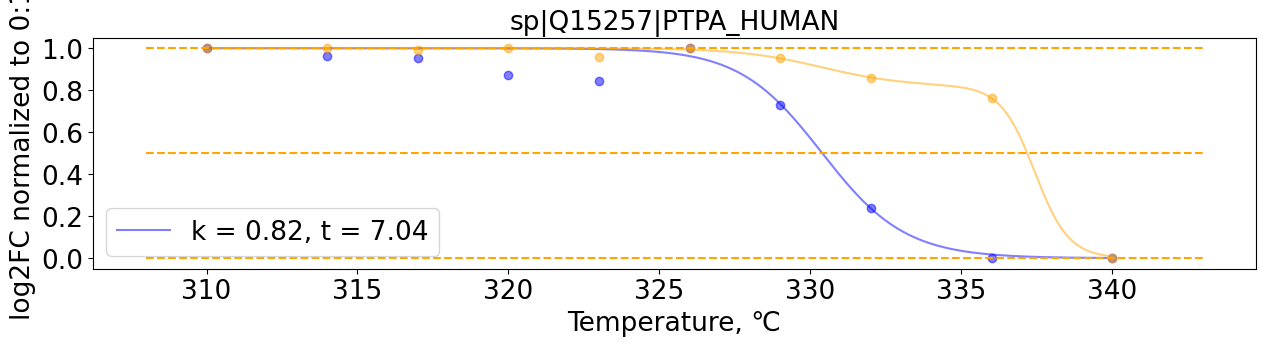

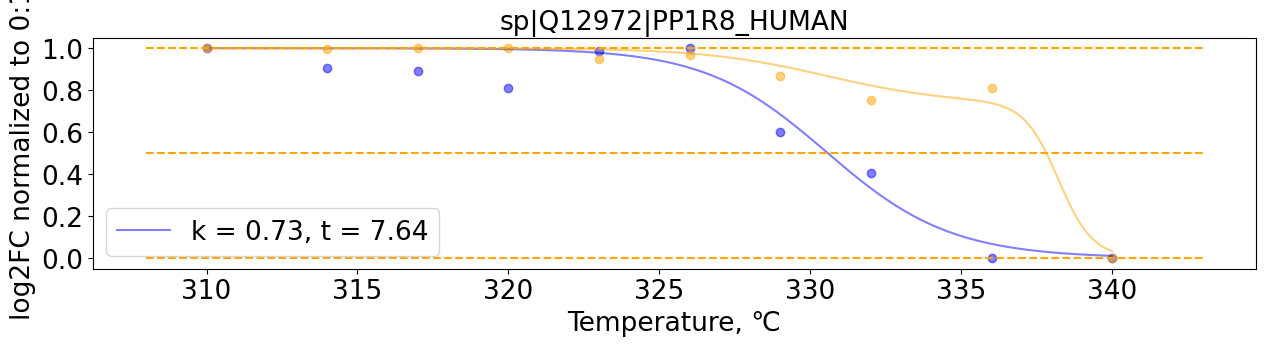

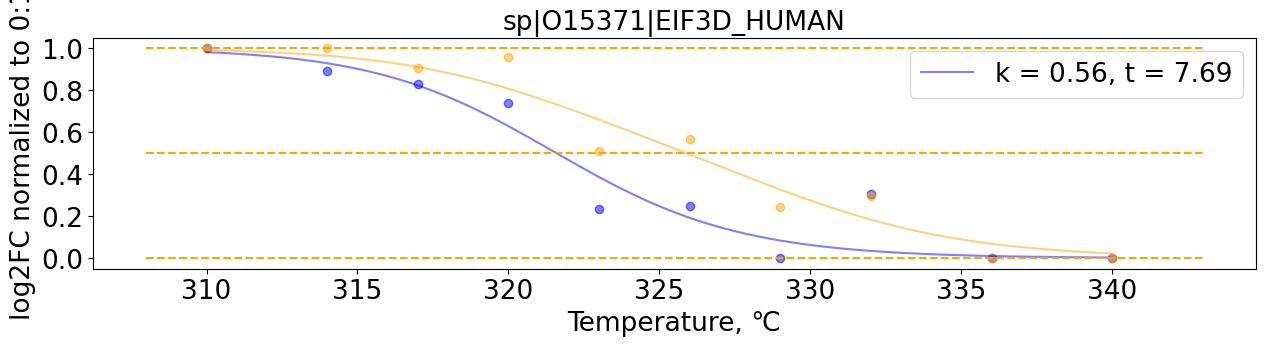

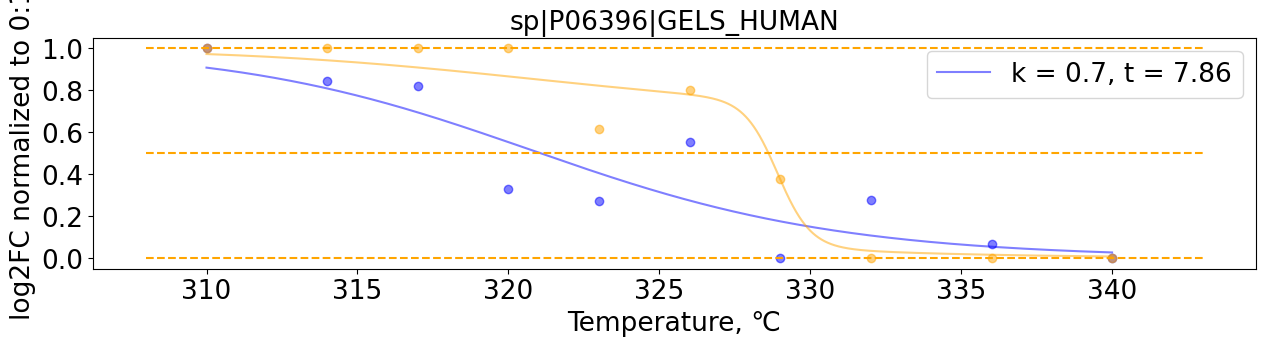

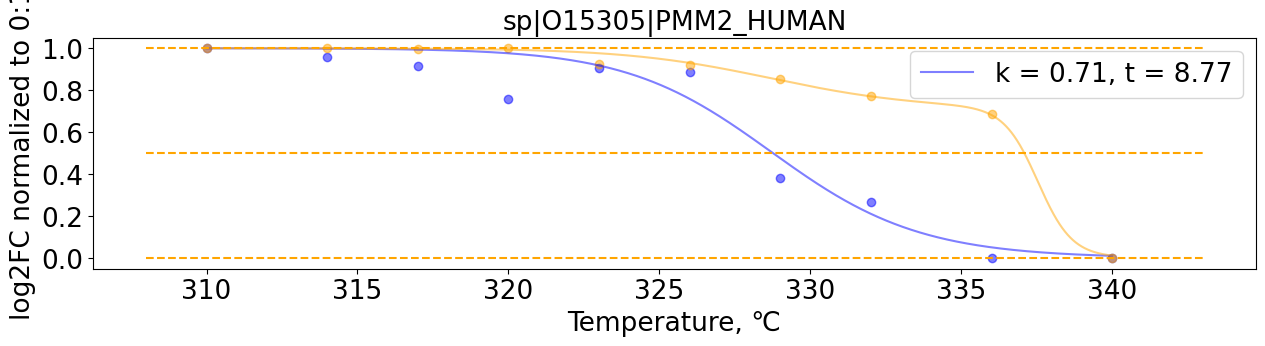

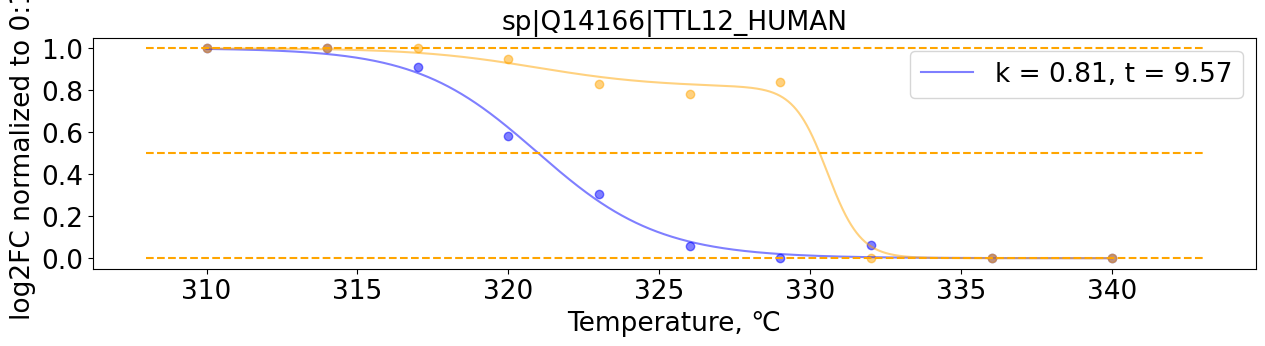

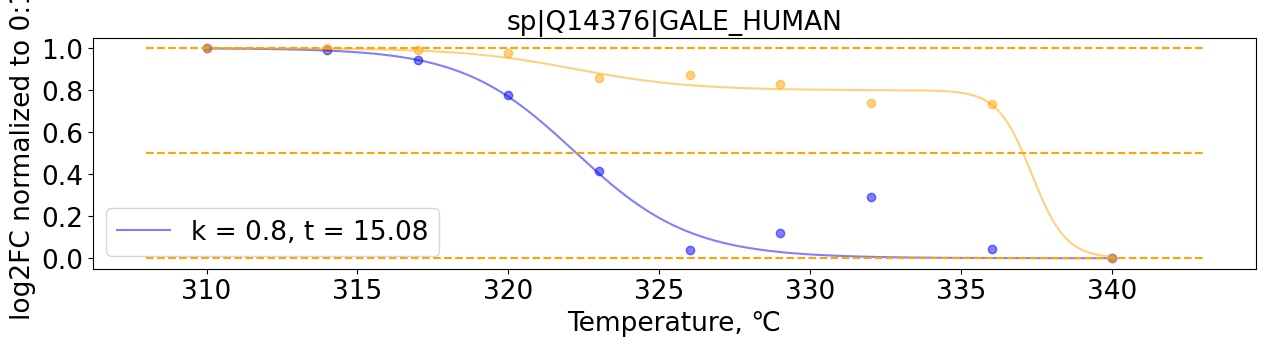

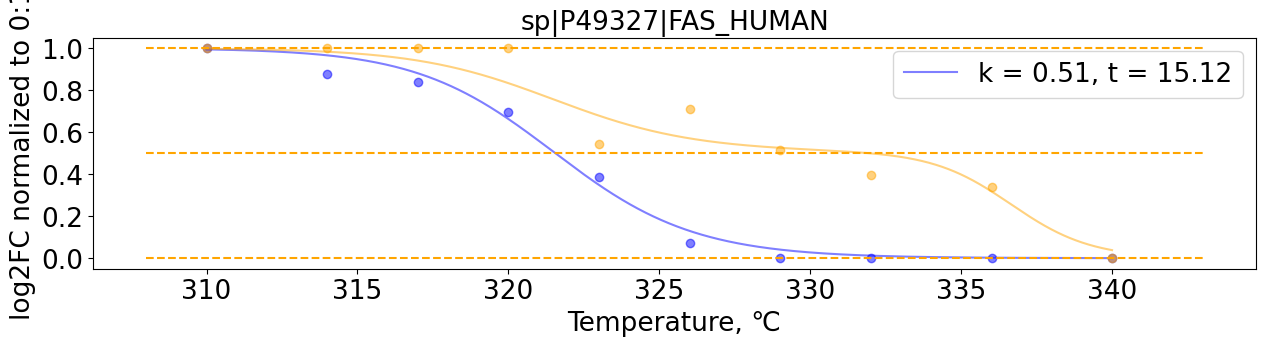

In [272]:
#Plot solubility curves for targets

# #########
# #########

difff = difff.dropna()
difff['nice']=difff.apply(lambda x: abs(x['difference'])>3*segma, axis=1)
difff1=difff[difff['nice']]
difff1 = difff1.sort_values(['r2'])
difff1 = difff1.reset_index(drop=True)
plt.scatter(difff1['difference'], difff1['r2'], label= f'number of proteins = {len(difff1)}', color='red')
plt.xlabel('difference')
plt.ylabel('R2')
plt.legend()
plt.title('scatter plot: R2/difference')

plt.show()         

#########
#########
difff1=difff1.sort_values(['difference'])
difff1 = difff1.reset_index(drop=True)

for i in range(len(difff1)):
        plt.figure(figsize=(15,3))
        plt.plot(np.arange(310, 340, 0.01), func(np.arange(310, 340, 0.01), difff1['a'][i], difff1['b'][i]), color = 'b', 
                 alpha=0.5, label = f"k = {round(difff1['k'][i],2)}, t = {round(difff1['t'][i],2)}")
        plt.plot(np.arange(310, 340, 0.01), 
                 func_new(np.arange(310, 340, 0.01), difff1['l'][i], difff1['t'][i], difff1['k'][i], difff1['a'][i], difff1['b'][i]), 
                 color='orange', 
                 alpha=0.5)
        plt.scatter(difff1['x_val'][i], difff1['y_val_K'][i],color='b', alpha=0.5)
        plt.scatter(difff1['x_val'][i], difff1['y_val_T'][i],color='orange', alpha=0.5)
        plt.hlines(0, 308, 343, color='orange', linestyles='--')
        plt.hlines(1, 308, 343, color='orange', linestyles='--')
        plt.hlines(0.5, 308, 343, color='orange', linestyles='--')
        plt.xlabel('Temperature, ℃',fontsize=19)
        plt.legend(fontsize=19)                                                       # строю графики этих белков
        plt.title(difff1['dbname'][i],fontsize=19)
        plt.ylabel('log2FC normalized to 0:1',fontsize=19)
        plt.xticks(fontsize=19)  
        plt.yticks(fontsize=19)  
        plt.show()
        
        

In [77]:
# END OF NEW FORMULA

In [78]:
from matplotlib_venn import venn2

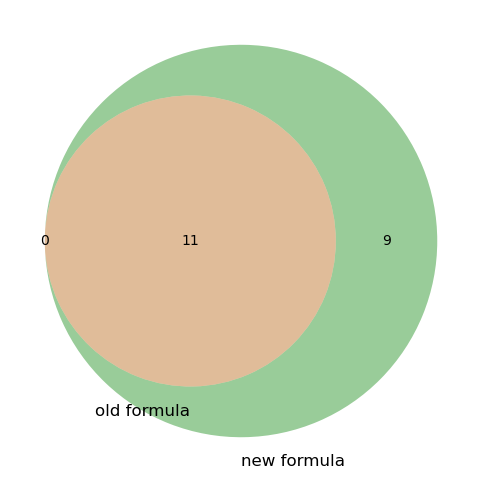

In [283]:
#Venn diagram for target for old and new formula

set1 = set(diff1['dbname'])
set2 = set(difff1['dbname'])

plt.figure(figsize=(8, 6))
venn2([set1, set2], set_labels=('old formula', 'new formula'))

plt.show()